In [ ]:

import pandas as pd
import numpy as np
import sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sqlalchemy import create_engine

user = 'postgres'
password = '18102001'
host = 'localhost'
port = '5433'
database = 'Plants'

conn_str = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}'

engine = create_engine(conn_str)

try:
    df = pd.read_sql("SELECT * FROM plant AS p INNER JOIN energy as e ON p.id_plant = e.id_plant INNER JOIN country as c ON p.id_country = c.id_country", engine)
    print(df.head())
except Exception as e:
    print("Errore di connessione o query:", e)



     id_plant id_country                            name  commissioning_year  \
0  WRI1071640        CHN                   Sichuan Guoru                 NaN   
1  BRA0028276        BRA             Kaiser - Araraquara              2001.0   
2  WRI1026386        ITA  Acquacandida Solar Power Plant                 NaN   
3  USA0055409        USA           Calhoun Energy Center              2003.0   
4  WKS0070259        CHN                      Shanshan J                 NaN   

  primary_fuel  capacity_mw  latitude  longitude    id_plant  \
0        Hydro         48.0   30.4600   101.4300  WRI1071640   
1          Oil          1.6  -21.7900   -48.1665  BRA0028276   
2        Solar          1.0   40.4240    17.4977  WRI1026386   
3          Gas        748.0   33.5883   -85.9731  USA0055409   
4        Solar         50.0   42.9610    90.0290  WKS0070259   

   generation_2013_gwh  generation_2014_gwh  generation_2015_gwh  \
0                  NaN                  NaN                  NaN  

In [ ]:
#preprocessing
#converto le colonne country_name e primary_fuel in variabili categoriche e poi in codici numerici
df['country_name'] = df['country_name'].astype('category').cat.codes
df['primary_fuel'] = df['primary_fuel'].astype('category').cat.codes

#divido la capacity di ogni riga per 1000 per avere valori uniformi
df['capacity_mw'] = df['capacity_mw'] / 1000

#cambio il nome di capacity_mw in capacity_gw
df.rename(columns={'capacity_mw': 'capacity_gw'}, inplace=True)



correlazione tra features e target1:
commissioning_year    -0.037971
country_name          -0.225698
capacity_gw            0.843724
latitude              -0.038374
longitude              0.219294
primary_fuel          -0.233289
generation_2013_gwh    0.933571
generation_2014_gwh    0.933094
generation_2015_gwh    0.958868
generation_2016_gwh    0.975514
dtype: float64


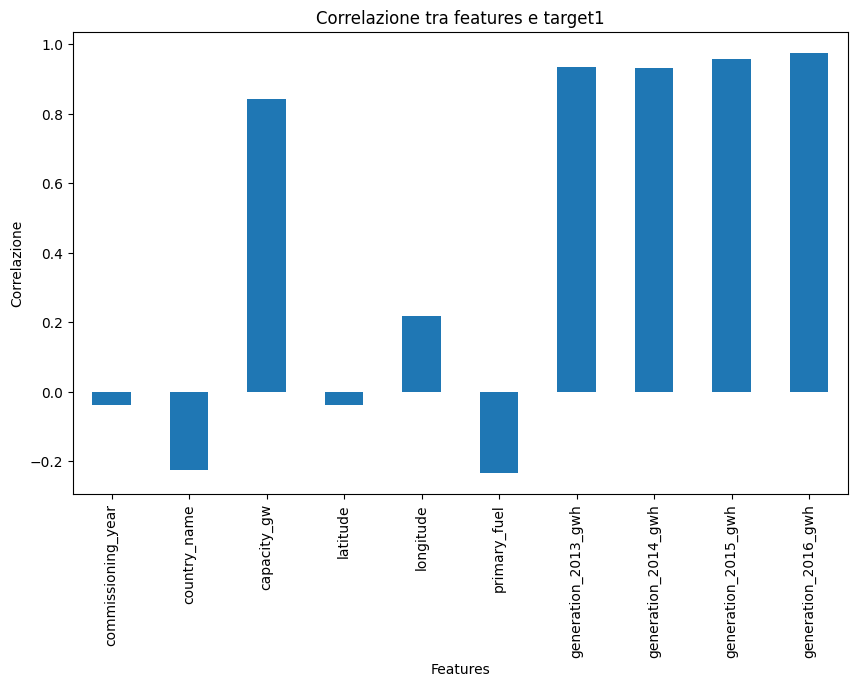

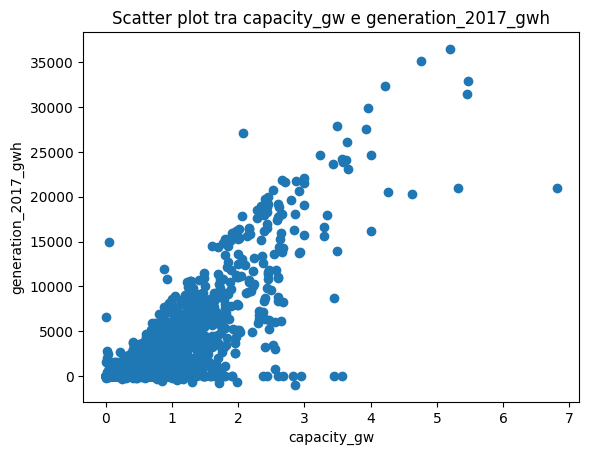

In [29]:
#correlazione tra features e target1
features_correlazione = ['commissioning_year','country_name','capacity_gw','latitude','longitude','primary_fuel','generation_2013_gwh','generation_2014_gwh','generation_2015_gwh','generation_2016_gwh']

correlation1 = df[features_correlazione].corrwith(df['generation_2017_gwh'])
print('correlazione tra features e target1:')
print(correlation1)

#grafico a barre della correlazione tra features e target1
plt.figure(figsize=(10,6))
correlation1.plot(kind='bar')
plt.title('Correlazione tra features e target1')
plt.xlabel('Features')
plt.ylabel('Correlazione')
plt.show()

#scatter plot tra capacity_gw e generation_2017_gwh
plt.scatter(df['capacity_gw'], df['generation_2017_gwh'])
plt.title('Scatter plot tra capacity_gw e generation_2017_gwh')
plt.xlabel('capacity_gw')
plt.ylabel('generation_2017_gwh')
plt.show()
     


In [ ]:
#training modelli su features con correlazione alta

features = ['capacity_gw','generation_2013_gwh','generation_2014_gwh','generation_2015_gwh','generation_2016_gwh']
target1 = 'generation_2017_gwh'
target2 = 'generation_2018_gwh'
target3 = 'generation_2019_gwh'
data = df[features]
data1 = df[[target1]]
data2 = df[[target2]]
data3 = df[[target3]]

# combino feature e target e rimuovo righe con NaN nelle colonne selezionate
combined1 = pd.concat([data, data1], axis=1)
combined2 = pd.concat([data, data2], axis=1)
combined3 = pd.concat([data, data3], axis=1)

n_before1 = combined1.shape[0]
n_before2 = combined2.shape[0]
n_before3 = combined3.shape[0]

# rimuovo righe con NaN nelle colonne selezionate (dropna)
combined_clean1 = combined1.dropna()
combined_clean2 = combined2.dropna()
combined_clean3 = combined3.dropna()

n_after1 = combined_clean1.shape[0]
n_after2 = combined_clean2.shape[0]
n_after3 = combined_clean3.shape[0]

print(f"Rows before: {n_before1}, after dropna: {n_after1} (dropped {n_before1-n_after1})")
print(f"Rows before: {n_before2}, after dropna: {n_after2} (dropped {n_before2-n_after2})")
print(f"Rows before: {n_before3}, after dropna: {n_after3} (dropped {n_before3-n_after3})")

# estraggo X e y da dati puliti
x1 = combined_clean1[features].values
y1 = combined_clean1[target1].values
x2 = combined_clean2[features].values
y2 = combined_clean2[target2].values
x3 = combined_clean3[features].values
y3 = combined_clean3[target3].values

print('X1 shape:', x1.shape, 'y1 shape:', y1.shape)
print('X2 shape:', x2.shape, 'y2 shape:', y2.shape)
print('X3 shape:', x3.shape, 'y3 shape:', y3.shape)

if x1.shape[0] == 0:
    raise ValueError('No rows left after dropping NaN in dataset 1. Consider imputing missing values instead.')
if x2.shape[0] == 0:
    raise ValueError('No rows left after dropping NaN in dataset 2. Consider imputing missing values instead.')
if x3.shape[0] == 0:
    raise ValueError('No rows left after dropping NaN in dataset 3. Consider imputing missing values instead.')

# divido in training e test set (80% train, 20% test)
X_train1, X_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=0.2, shuffle=False)
X_train2, X_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, shuffle=False)
X_train3, X_test3, y_train3, y_test3 = train_test_split(x3, y3, test_size=0.2, shuffle=False)

# converti y in vettore 1D per evitare DataConversionWarning
y_train1 = y_train1.ravel()
y_test1 = y_test1.ravel()
y_train2 = y_train2.ravel()
y_test2 = y_test2.ravel()
y_train3 = y_train3.ravel()
y_test3 = y_test3.ravel()

print("*** Linear Regression 1 ***")
clf = LinearRegression()
clf.fit(X_train1, y_train1)
y_lr1_pred = clf.predict(X_test1)
print('MAE:', mean_absolute_error(y_test1, y_lr1_pred))
print('MSE:', mean_squared_error(y_test1, y_lr1_pred))

print("*** Random Forest 1 ***")
clf = RandomForestRegressor()
clf.fit(X_train1, y_train1)
y_rf1_pred = clf.predict(X_test1)
print('MAE:', mean_absolute_error(y_test1, y_rf1_pred))
print('MSE:', mean_squared_error(y_test1, y_rf1_pred))

# STANDARDIZZA LE FEATURE PER KNN
#scaler_knn = StandardScaler()
#X_train1= scaler_knn.fit_transform(X_train1)
#X_test1 = scaler_knn.transform(X_test1)

# LE HO IDENTATE PERCHE' FUNZIONA PEGGIO !!!

print("*** KNN Regression 1 ***")
clf = KNeighborsRegressor(n_neighbors=20)
clf.fit(X_train1, y_train1)
y_knn1_pred = clf.predict(X_test1)
print('MAE:', mean_absolute_error(y_test1, y_knn1_pred))
print('MSE:', mean_squared_error(y_test1, y_knn1_pred))

print("*** Linear Regression 2 ***")
clf = LinearRegression()
clf.fit(X_train2, y_train2)
y_lr2_pred = clf.predict(X_test2)
print('MAE:', mean_absolute_error(y_test2, y_lr2_pred))
print('MSE:', mean_squared_error(y_test2, y_lr2_pred))

print("*** Random Forest 2 ***")
clf = RandomForestRegressor(random_state=42)
clf.fit(X_train2, y_train2)
y_rf2_pred = clf.predict(X_test2)
print('MAE:', mean_absolute_error(y_test2, y_rf2_pred))
print('MSE:', mean_squared_error(y_test2, y_rf2_pred))

print("*** KNN Regression 2 ***")
clf = KNeighborsRegressor(n_neighbors=20)
clf.fit(X_train2, y_train2)
y_knn2_pred = clf.predict(X_test2)
print('MAE:', mean_absolute_error(y_test2, y_knn2_pred))
print('MSE:', mean_squared_error(y_test2, y_knn2_pred))

print("*** Linear Regression 3 ***")
clf = LinearRegression()
clf.fit(X_train3, y_train3)
y_lr3_pred = clf.predict(X_test3)
print('MAE:', mean_absolute_error(y_test3, y_lr3_pred))
print('MSE:', mean_squared_error(y_test3, y_lr3_pred))

print("*** Random Forest 3 ***")
clf = RandomForestRegressor(random_state=42)
clf.fit(X_train3, y_train3)
y_rf3_pred = clf.predict(X_test3)
print('MAE:', mean_absolute_error(y_test3, y_rf3_pred))
print('MSE:', mean_squared_error(y_test3, y_rf3_pred))

print("*** KNN Regression 3 ***")
clf = KNeighborsRegressor(n_neighbors=20)
clf.fit(X_train3, y_train3)
y_knn3_pred = clf.predict(X_test3)
print('MAE:', mean_absolute_error(y_test3, y_knn3_pred))
print('MSE:', mean_squared_error(y_test3, y_knn3_pred))


Rows before: 34936, after dropna: 6253 (dropped 28683)
Rows before: 34936, after dropna: 6256 (dropped 28680)
Rows before: 34936, after dropna: 6044 (dropped 28892)
X1 shape: (6253, 5) y1 shape: (6253,)
X2 shape: (6256, 5) y2 shape: (6256,)
X3 shape: (6044, 5) y3 shape: (6044,)
*** Linear Regression 1 ***
MAE: 120.79753167111585
MSE: 358341.54700628726
*** Random Forest 1 ***
MAE: 120.00658733396521
MSE: 566729.5016179854
*** KNN Regression 1 ***
MAE: 131.89385411670662
MSE: 484115.8085052547
*** Linear Regression 2 ***
MAE: 114.21531631467475
MSE: 251233.95983319997
*** Random Forest 2 ***
MAE: 132.6985675088574
MSE: 379664.2719858166
*** KNN Regression 2 ***
MAE: 145.42035223642173
MSE: 439736.8557587739
*** Linear Regression 3 ***
MAE: 164.8966217231818
MSE: 306292.80999686
*** Random Forest 3 ***
MAE: 141.12935478581457
MSE: 276665.0632343064
*** KNN Regression 3 ***
MAE: 149.58705541770058
MSE: 449287.0226265637


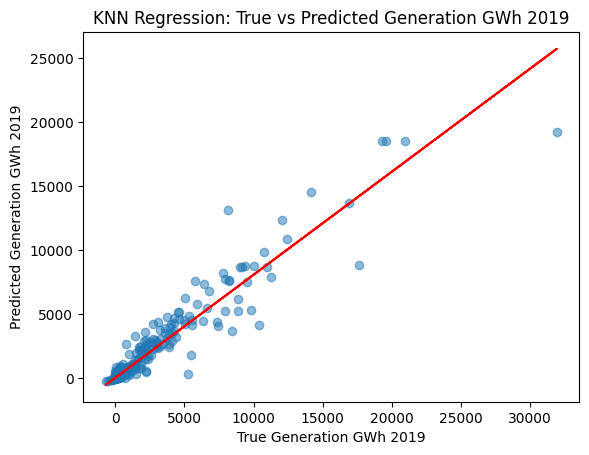

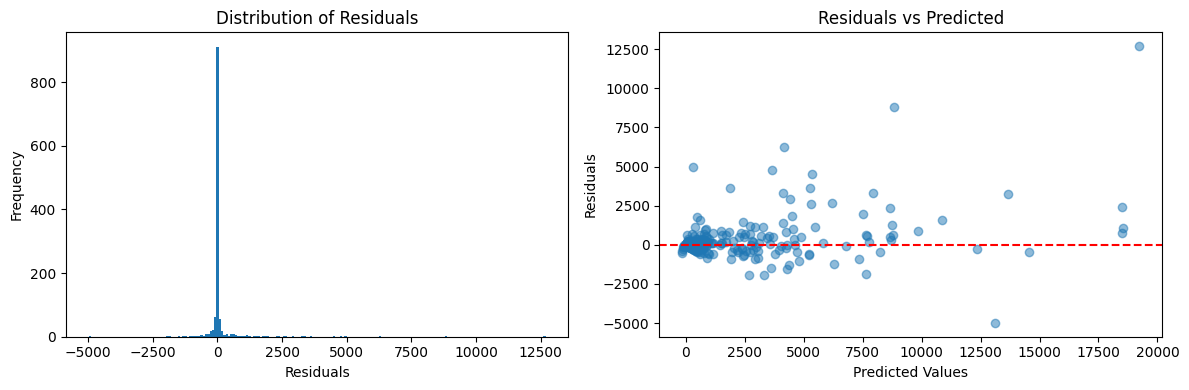

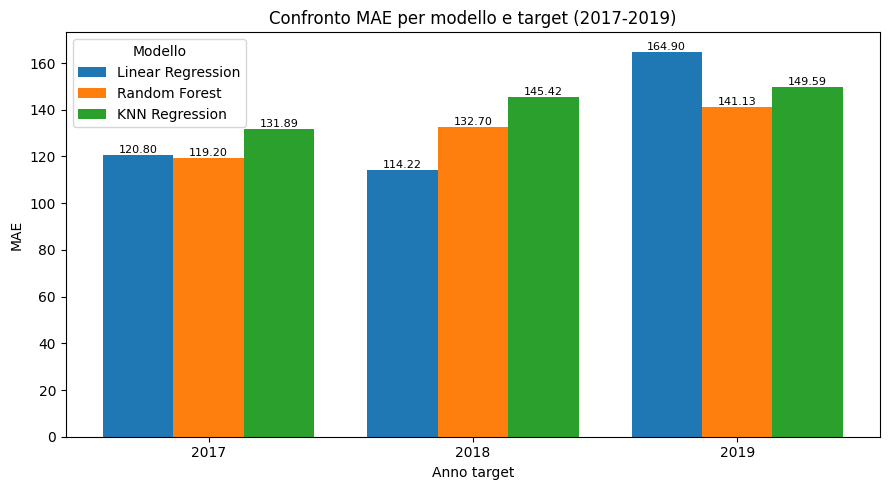

In [ ]:
# grafico KNN Regression 3: true vs predicted
plt.scatter(y_test3, y_knn3_pred, alpha=0.5)
plt.xlabel('True Generation GWh 2019')
plt.ylabel('Predicted Generation GWh 2019')
ax = plt.gca()
ax.plot(y_test3, np.poly1d(np.polyfit(y_test3, y_knn3_pred, 1))(y_test3), color='red')
plt.title('KNN Regression: True vs Predicted Generation GWh 2019')
plt.plot([0, 0.5], [0, 0.5], 'k--', lw=2)
plt.show()  


# grafico KNN Regression 3: residuals
errore = y_test3 - y_knn3_pred
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(errore, bins=200)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

plt.subplot(1, 2, 2)
plt.scatter(y_knn3_pred, errore, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.tight_layout()
plt.show()


# Calcolo MAE 
mae_values = {
    'Linear Regression': [
        mean_absolute_error(y_test1, y_lr1_pred),
        mean_absolute_error(y_test2, y_lr2_pred),
        mean_absolute_error(y_test3, y_lr3_pred)
    ],
    'Random Forest': [
        mean_absolute_error(y_test1, y_rf1_pred),
        mean_absolute_error(y_test2, y_rf2_pred),
        mean_absolute_error(y_test3, y_rf3_pred)
    ],
    'KNN Regression': [
        mean_absolute_error(y_test1, y_knn1_pred),
        mean_absolute_error(y_test2, y_knn2_pred),
        mean_absolute_error(y_test3, y_knn3_pred)
    ]
}

models = list(mae_values.keys())
targets = ['2017', '2018', '2019']
vals = np.array([mae_values[m] for m in models])  # shape (n_models, 3)

x = np.arange(len(targets))
n = len(models)
width = 0.8 / n

fig, ax = plt.subplots(figsize=(9,5))
for i, m in enumerate(models):
    ax.bar(x + (i - (n-1)/2)*width, vals[i], width=width, label=m)

ax.set_xticks(x)
ax.set_xticklabels(targets)
ax.set_xlabel('Anno target')
ax.set_ylabel('MAE')
ax.set_title('Confronto MAE per modello e target (2017-2019)')
ax.legend(title='Modello')
for i in range(n):
    for j in range(len(targets)):
        ax.text(x[j] + (i - (n-1)/2)*width, vals[i,j], f'{vals[i,j]:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()



CONFRONTO RISPETTO ALLA BASELINE:
 
risultati finali per generation_gwh_2019:
 
	MAE tra y_test3 e y3_media: 162.6414371381307
 
	MAE tra y_test3 e y_pred knn3: 149.58705541770058
	Riduzione percentuale del MAE di KNN3 rispetto alla media: 8.03%
 
	MAE tra y_test3 e y_pred rf3: 141.12935478581457
	Riduzione percentuale del MAE di RF3 rispetto alla media: 13.23%
 
	MAE tra y_test3 e y_pred lr3: 164.8966217231818
	Riduzione percentuale del MAE di LR3 rispetto alla media: -1.39%
 
risultati finali per generation_gwh_2018:
 
	MAE tra y_test2 e y2_media: 131.36240615015976
 
	MAE tra y_test2 e y_pred knn2: 145.42035223642173
	Riduzione percentuale del MAE di KNN2 rispetto alla media: -10.70%
 
	MAE tra y_test2 e y_pred rf2: 132.6985675088574
	Riduzione percentuale del MAE di RF2 rispetto alla media: -1.02%
 
	MAE tra y_test2 e y_pred lr2: 114.21531631467475
	Riduzione percentuale del MAE di LR2 rispetto alla media: 13.05%
 
risultati finali per generation_gwh_2017:
 
	MAE tra y_test1 e y1_m

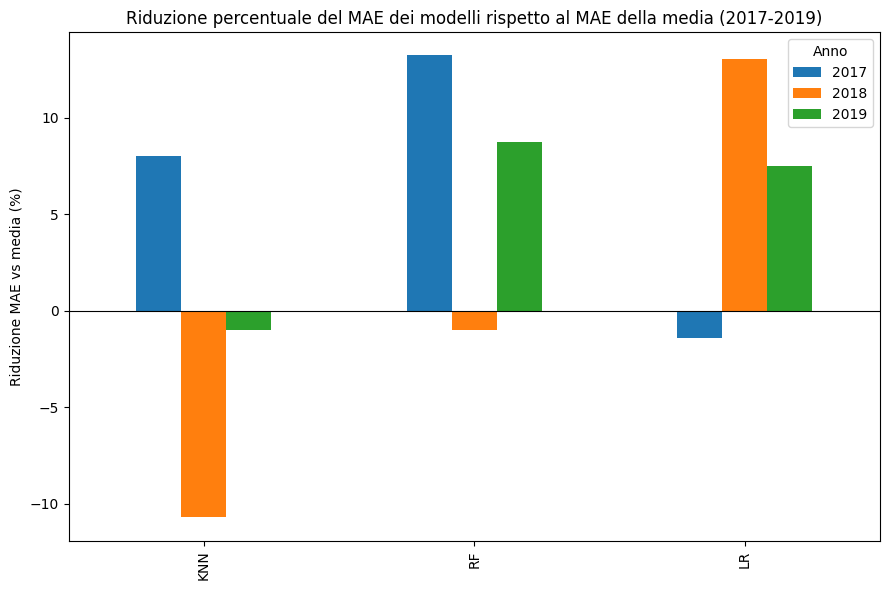

In [ ]:
print("="*60)
print('CONFRONTO RISPETTO ALLA BASELINE:')
print("="*60)
print(' ')

print("="*60)
print('risultati finali per generation_gwh_2019:')
print("="*60)
print(' ')

df_media = combined_clean3[['generation_2013_gwh', 'generation_2014_gwh', 'generation_2015_gwh', 'generation_2016_gwh','generation_2019_gwh']]

#calcolo la media delle colonne da generation_gwh_2013 a generation_gwh_2016 e la salvo nella colonna generation_gwh_2019
df_media['generation_2019_gwh'] = df_media[['generation_2013_gwh', 'generation_2014_gwh', 'generation_2015_gwh', 'generation_2016_gwh']].mean(axis=1)
y3_media = df_media['generation_2019_gwh'].values

#voglio gli ultimi 20% di y3_media per confrontarli con y_test3(per usare stessi dati)
n_test3 = len(y_test3)
y3_media = y3_media[-n_test3:]

mae_media = mean_absolute_error(y_test3, y3_media)
print('\tMAE tra y_test3 e y3_media:', mean_absolute_error(y_test3, y3_media))
print(' ')

print('\tMAE tra y_test3 e y_pred knn3:', mean_absolute_error(y_test3, y_knn3_pred))
mae_knn = mean_absolute_error(y_test3, y_knn3_pred)
reduction = ((mae_media - mae_knn) / mae_media) * 100
print(f'\tRiduzione percentuale del MAE di KNN3 rispetto alla media: {reduction:.2f}%')
print(' ')

print('\tMAE tra y_test3 e y_pred rf3:', mean_absolute_error(y_test3, y_rf3_pred))
mae_rf = mean_absolute_error(y_test3, y_rf3_pred)
reduction = ((mae_media - mae_rf) / mae_media) * 100
print(f'\tRiduzione percentuale del MAE di RF3 rispetto alla media: {reduction:.2f}%')
print(' ')

print('\tMAE tra y_test3 e y_pred lr3:', mean_absolute_error(y_test3, y_lr3_pred))
mae_lr = mean_absolute_error(y_test3, y_lr3_pred)
reduction = ((mae_media - mae_lr) / mae_media) * 100
print(f'\tRiduzione percentuale del MAE di LR3 rispetto alla media: {reduction:.2f}%')
print(' ')

print("="*60)
print('risultati finali per generation_gwh_2018:')
print("="*60)
print(' ')


df_media = combined_clean2[['generation_2013_gwh', 'generation_2014_gwh', 'generation_2015_gwh', 'generation_2016_gwh','generation_2018_gwh']]

#calcolo la media delle colonne da generation_gwh_2013 a generation_gwh_2016 e la salvo nella colonna generation_gwh_2018
df_media['generation_2018_gwh'] = df_media[['generation_2013_gwh', 'generation_2014_gwh', 'generation_2015_gwh', 'generation_2016_gwh']].mean(axis=1)
y2_media = df_media['generation_2018_gwh'].values

#voglio gli ultimi 20% di y2_media per confrontarli con y_test2(per usare stessi dati)
n_test2 = len(y_test2)
y2_media = y2_media[-n_test2:]
mae_media = mean_absolute_error(y_test2, y2_media)
print('\tMAE tra y_test2 e y2_media:', mean_absolute_error(y_test2, y2_media))
print(' ')

print('\tMAE tra y_test2 e y_pred knn2:', mean_absolute_error(y_test2, y_knn2_pred))
mae_knn = mean_absolute_error(y_test2, y_knn2_pred)
reduction = ((mae_media - mae_knn) / mae_media) * 100
print(f'\tRiduzione percentuale del MAE di KNN2 rispetto alla media: {reduction:.2f}%')
print(' ')

print('\tMAE tra y_test2 e y_pred rf2:', mean_absolute_error(y_test2, y_rf2_pred))
mae_rf = mean_absolute_error(y_test2, y_rf2_pred)
reduction = ((mae_media - mae_rf) / mae_media) * 100
print(f'\tRiduzione percentuale del MAE di RF2 rispetto alla media: {reduction:.2f}%')
print(' ')

print('\tMAE tra y_test2 e y_pred lr2:', mean_absolute_error(y_test2, y_lr2_pred))
mae_lr = mean_absolute_error(y_test2, y_lr2_pred)
reduction = ((mae_media - mae_lr) / mae_media) * 100
print(f'\tRiduzione percentuale del MAE di LR2 rispetto alla media: {reduction:.2f}%')
print(' ')

print("="*60)
print('risultati finali per generation_gwh_2017:')
print("="*60)
print(' ')

df_media = combined_clean1[['generation_2013_gwh', 'generation_2014_gwh', 'generation_2015_gwh', 'generation_2016_gwh','generation_2017_gwh']]

#calcolo la media delle colonne da generation_gwh_2013 a generation_gwh_2016 e la salvo nella colonna generation_gwh_2017
df_media['generation_2017_gwh'] = df_media[['generation_2013_gwh', 'generation_2014_gwh', 'generation_2015_gwh', 'generation_2016_gwh']].mean(axis=1)
y1_media = df_media['generation_2017_gwh'].values

#voglio gli ultimi 20% di y1_media per confrontarli con y_test1
n_test2 = len(y_test1)
y1_media = y1_media[-n_test2:]

mae_media = mean_absolute_error(y_test1, y1_media)
print('\tMAE tra y_test1 e y1_media:', mean_absolute_error(y_test1, y1_media))
print(' ')

print('\tMAE tra y_test1 e y_pred knn1:', mean_absolute_error(y_test1, y_knn1_pred))
mae_knn = mean_absolute_error(y_test1, y_knn1_pred)
reduction = ((mae_media - mae_knn) / mae_media) * 100
print(f'\tRiduzione percentuale del MAE di KNN1 rispetto alla media: {reduction:.2f}%')
print(' ')

print('\tMAE tra y_test1 e y_pred rf1:', mean_absolute_error(y_test1, y_rf1_pred))
mae_rf = mean_absolute_error(y_test1, y_rf1_pred)
reduction = ((mae_media - mae_rf) / mae_media) * 100
print(f'\tRiduzione percentuale del MAE di RF1 rispetto alla media: {reduction:.2f}%')
print(' ')

print('\tMAE tra y_test1 e y_pred lr1:', mean_absolute_error(y_test1, y_lr1_pred))
mae_lr = mean_absolute_error(y_test1, y_lr1_pred)
reduction = ((mae_media - mae_lr) / mae_media) * 100
print(f'\tRiduzione percentuale del MAE di LR1 rispetto alla media: {reduction:.2f}%')
print(' ')


# Grafico: Riduzione percentuale del MAE di KNN, RF e LR rispetto alla media (2017-2019)
years = [2017, 2018, 2019]
models = ['KNN', 'RF', 'LR']
reductions = {m: [] for m in models}

# funzione helper che calcola la riduzione percentuale rispetto alla media con check per mae_media==0
def pct_reduction(mae_media, mae_model):
    if mae_media == 0 or np.isnan(mae_media):
        return 0.0
    return ((mae_media - mae_model) / mae_media) * 100

# ANNO 2019 (dataset 3)
df_media = combined_clean3[['generation_2013_gwh','generation_2014_gwh','generation_2015_gwh','generation_2016_gwh']]
y3_media = df_media.mean(axis=1).values
y3_media = y3_media[-len(y_test3):]
mae_media = mean_absolute_error(y_test3, y3_media)
mae_knn = mean_absolute_error(y_test3, y_knn3_pred)
mae_rf  = mean_absolute_error(y_test3, y_rf3_pred)
mae_lr  = mean_absolute_error(y_test3, y_lr3_pred)
reductions['KNN'].append(pct_reduction(mae_media, mae_knn))
reductions['RF'].append(pct_reduction(mae_media, mae_rf))
reductions['LR'].append(pct_reduction(mae_media, mae_lr))

# ANNO 2018 (dataset 2)
df_media = combined_clean2[['generation_2013_gwh','generation_2014_gwh','generation_2015_gwh','generation_2016_gwh']]
y2_media = df_media.mean(axis=1).values
y2_media = y2_media[-len(y_test2):]
mae_media = mean_absolute_error(y_test2, y2_media)
mae_knn = mean_absolute_error(y_test2, y_knn2_pred)
mae_rf  = mean_absolute_error(y_test2, y_rf2_pred)
mae_lr  = mean_absolute_error(y_test2, y_lr2_pred)
reductions['KNN'].append(pct_reduction(mae_media, mae_knn))
reductions['RF'].append(pct_reduction(mae_media, mae_rf))
reductions['LR'].append(pct_reduction(mae_media, mae_lr))

# ANNO 2017 (dataset 1)
df_media = combined_clean1[['generation_2013_gwh','generation_2014_gwh','generation_2015_gwh','generation_2016_gwh']]
y1_media = df_media.mean(axis=1).values
y1_media = y1_media[-len(y_test1):]
mae_media = mean_absolute_error(y_test1, y1_media)
mae_knn = mean_absolute_error(y_test1, y_knn1_pred)
mae_rf  = mean_absolute_error(y_test1, y_rf1_pred)
mae_lr  = mean_absolute_error(y_test1, y_lr1_pred)
reductions['KNN'].append(pct_reduction(mae_media, mae_knn))
reductions['RF'].append(pct_reduction(mae_media, mae_rf))
reductions['LR'].append(pct_reduction(mae_media, mae_lr))

# Crea DataFrame: righe=modelli, colonne=anni
reductions_df = pd.DataFrame(reductions, index=years).T
reductions_df.columns = [str(y) for y in years]

print('Riduzioni percentuali del MAE rispetto alla media (in %):')
print(reductions_df.round(2).to_string())

# Grafico a barre raggruppate
ax = reductions_df.plot(kind='bar', figsize=(9,6))
ax.set_ylabel('Riduzione MAE vs media (%)')
ax.set_title('Riduzione percentuale del MAE dei modelli rispetto al MAE della media (2017-2019)')
ax.axhline(0, color='k', linewidth=0.8)
ax.legend(title='Anno')
plt.tight_layout()
plt.show()




In [ ]:
# GridSearchCV ottimizzato su MAE per RF e KNN (target 2019)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# controlli preliminari
required = ['X_train3','X_test3','y_train3','y_test3']
missing = [v for v in required if v not in globals()]
if missing:
    raise NameError(f"Variabili mancanti nel kernel: {missing}. Esegui la preparazione dei dataset (cell che crea X_train3/X_test3/y_train3/y_test3).")

# RANDOM FOREST ottimizzato su MAE
param_grid_rf_mae = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid_mae = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf_mae,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)
rf_grid_mae.fit(X_train3, y_train3)
rf_best_mae = rf_grid_mae.best_estimator_
y_pred_rf_best_mae = rf_best_mae.predict(X_test3)
mae_rf_best_mae = mean_absolute_error(y_test3, y_pred_rf_best_mae)
print('RF best params (MAE):', rf_grid_mae.best_params_)
print('RF test MAE (best by MAE):', mae_rf_best_mae)

# KNN ottimizzato su MAE senza normalizzazione
param_grid_knn_mae = {
    'n_neighbors': [5, 10, 20, 30],
    'weights': ['uniform','distance']
}
knn_grid_mae = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=param_grid_knn_mae,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    verbose=1,
)
knn_grid_mae.fit(X_train3, y_train3)
knn_best_mae = knn_grid_mae.best_estimator_
y_pred_knn_best_mae = knn_best_mae.predict(X_test3)
mae_knn_best_mae = mean_absolute_error(y_test3, y_pred_knn_best_mae)
print('KNN best params (MAE):', knn_grid_mae.best_params_)
print('KNN test MAE (best by MAE):', mae_knn_best_mae)

# Salva anche le predizioni originali se non esistono 
if 'y_rf3_pred' in globals():
    print('MAE RF original (y_rf3_pred):', mean_absolute_error(y_test3, y_rf3_pred))
if 'y_knn3_pred' in globals():
    print('MAE KNN original (y_knn3_pred):', mean_absolute_error(y_test3, y_knn3_pred))


Fitting 3 folds for each of 36 candidates, totalling 108 fits
RF best params (MAE): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
RF test MAE (best by MAE): 139.0364246776637
Fitting 3 folds for each of 8 candidates, totalling 24 fits
KNN best params (MAE): {'n_neighbors': 10, 'weights': 'distance'}
KNN test MAE (best by MAE): 142.65956105813325
MAE RF original (y_rf3_pred): 141.12935478581457
MAE KNN original (y_knn3_pred): 149.58705541770058

Done. Variabili create: rf_best_mae, knn_best_mae, y_pred_rf_best_mae, y_pred_knn_best_mae


Metriche (target 2019): MAE | R2
 - RF Optimized: MAE=139.0364 | R2=0.9424
 - KNN Optimized: MAE=142.6596 | R2=0.9256
 - RF Original: MAE=141.1294 | R2=0.9411
 - KNN Original: MAE=149.5871 | R2=0.9044


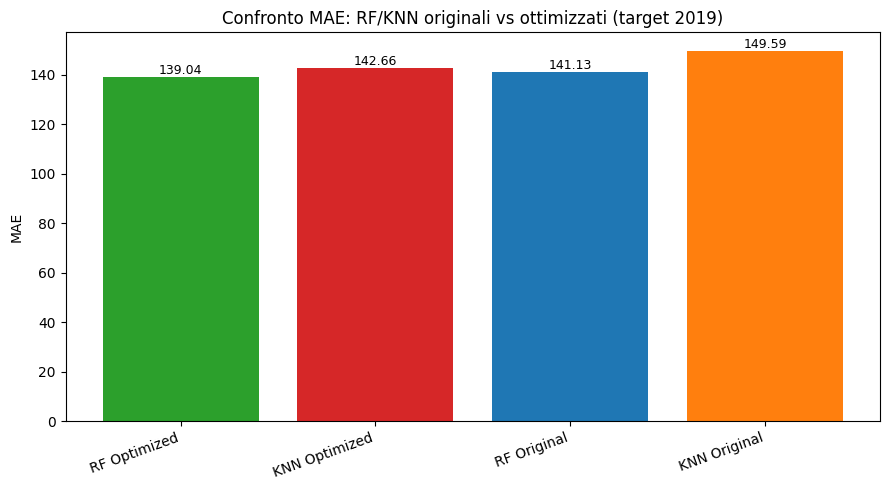

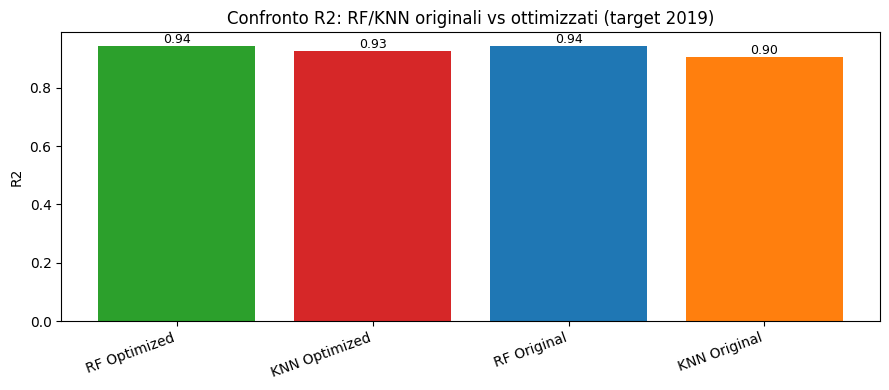

In [36]:

# helper per prendere la prima variabile esistente tra alternative
def pick(*names):
    for n in names:
        if n in globals():
            return globals()[n]
    return None

# requisiti / alternative — ricerca sia le predizioni ottimizzate per MAE che quelle ottimizzate per R2
y_test3 = pick('y_test3')
rf_opt = pick('y_pred_rf_best_mae', 'y_pred_rf_best')
knn_opt = pick('y_pred_knn_best_mae', 'y_pred_knn_best')
rf_orig = pick('y_rf3_pred', 'y_pred_rf_original')
knn_orig = pick('y_knn3_pred', 'y_pred_knn_original_unscaled', 'y_pred_knn_original_scaled')

missing = [name for name, var in [
    ('y_test3', y_test3), ('rf_opt', rf_opt), ('knn_opt', knn_opt), ('rf_orig', rf_orig), ('knn_orig', knn_orig)
] if var is None]

if missing:
    raise NameError(f"Variabili mancanti nel kernel: {missing}. Esegui le celle di training/ottimizzazione per target 2019.")

# allinea lunghezze se necessario (se predizioni più lunghe, prendi gli ultimi len(y_test3))
def align(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if len(y_pred) == len(y_true):
        return y_true, y_pred
    if len(y_pred) > len(y_true):
        return y_true, y_pred[-len(y_true):]
    raise ValueError(f"Predizioni più corte di y_true ({len(y_pred)} < {len(y_true)})")

y_true, rf_opt_al = align(y_test3, rf_opt)
_, knn_opt_al = align(y_test3, knn_opt)
_, rf_orig_al = align(y_test3, rf_orig)
_, knn_orig_al = align(y_test3, knn_orig)

# Calcola sia MAE che R2 per completezza
metrics = {
    'RF Optimized': (mean_absolute_error(y_true, rf_opt_al), r2_score(y_true, rf_opt_al)),
    'KNN Optimized': (mean_absolute_error(y_true, knn_opt_al), r2_score(y_true, knn_opt_al)),
    'RF Original': (mean_absolute_error(y_true, rf_orig_al), r2_score(y_true, rf_orig_al)),
    'KNN Original': (mean_absolute_error(y_true, knn_orig_al), r2_score(y_true, knn_orig_al))
}

# Stampa riepilogo metriche
print("Metriche (target 2019): MAE | R2")
for k, (mae, r2) in metrics.items():
    print(f" - {k}: MAE={mae:.4f} | R2={r2:.4f}")

# Grafico a barre: MAE (ordinato)
labels = list(metrics.keys())
mae_values = [metrics[l][0] for l in labels]
x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(9,5))
bars = ax.bar(x, mae_values, color=['C2','C3','C0','C1'])
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=20, ha='right')
ax.set_ylabel('MAE')
ax.set_title('Confronto MAE: RF/KNN originali vs ottimizzati (target 2019)')
for b in bars:
    h = b.get_height()
    ax.text(b.get_x()+b.get_width()/2, h, f'{h:.2f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# Grafico aggiuntivo: R2
r2_values = [metrics[l][1] for l in labels]
fig, ax = plt.subplots(figsize=(9,4))
bars = ax.bar(x, r2_values, color=['C2','C3','C0','C1'])
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=20, ha='right')
ax.set_ylabel('R2')
ax.set_title('Confronto R2: RF/KNN originali vs ottimizzati (target 2019)')
for b in bars:
    h = b.get_height()
    ax.text(b.get_x()+b.get_width()/2, h, f'{h:.2f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

In [37]:
print('risultati con features_correlazione:')
features_correlazione = ['commissioning_year','country_name','capacity_gw','latitude','longitude','primary_fuel','generation_2013_gwh','generation_2014_gwh','generation_2015_gwh','generation_2016_gwh']

target1 = 'generation_2017_gwh'
target2 = 'generation_2018_gwh'
target3 = 'generation_2019_gwh'
data = df[features_correlazione]
data1 = df[[target1]]
data2 = df[[target2]]
data3 = df[[target3]]

# combino feature e target e rimuovo righe con NaN nelle colonne selezionate
combined1 = pd.concat([data, data1], axis=1)
combined2 = pd.concat([data, data2], axis=1)
combined3 = pd.concat([data, data3], axis=1)

n_before1 = combined1.shape[0]
n_before2 = combined2.shape[0]
n_before3 = combined3.shape[0]

# rimuovo righe con NaN nelle colonne selezionate (dropna)
combined_clean1 = combined1.dropna()
combined_clean2 = combined2.dropna()
combined_clean3 = combined3.dropna()

n_after1 = combined_clean1.shape[0]
n_after2 = combined_clean2.shape[0]
n_after3 = combined_clean3.shape[0]

print(f"Rows before: {n_before1}, after dropna: {n_after1} (dropped {n_before1-n_after1})")
print(f"Rows before: {n_before2}, after dropna: {n_after2} (dropped {n_before2-n_after2})")
print(f"Rows before: {n_before3}, after dropna: {n_after3} (dropped {n_before3-n_after3})")

# estraggo X e y da dati puliti
x1 = combined_clean1[features_correlazione].values
y1 = combined_clean1[target1].values
x2 = combined_clean2[features_correlazione].values
y2 = combined_clean2[target2].values
x3 = combined_clean3[features_correlazione].values
y3 = combined_clean3[target3].values

print('X1 shape:', x1.shape, 'y1 shape:', y1.shape)
print('X2 shape:', x2.shape, 'y2 shape:', y2.shape)
print('X3 shape:', x3.shape, 'y3 shape:', y3.shape)

if x1.shape[0] == 0:
    raise ValueError('No rows left after dropping NaN in dataset 1. Consider imputing missing values instead.')
if x2.shape[0] == 0:
    raise ValueError('No rows left after dropping NaN in dataset 2. Consider imputing missing values instead.')
if x3.shape[0] == 0:
    raise ValueError('No rows left after dropping NaN in dataset 3. Consider imputing missing values instead.')

# divido in training e test set (80% train, 20% test), senza shuffle per dati temporali
X_train1, X_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=0.2, shuffle=False)
X_train2, X_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, shuffle=False)
X_train3, X_test3, y_train3, y_test3 = train_test_split(x3, y3, test_size=0.2, shuffle=False)

# converti y in vettore 1D per evitare DataConversionWarning
y_train1 = y_train1.ravel()
y_test1 = y_test1.ravel()
y_train2 = y_train2.ravel()
y_test2 = y_test2.ravel()
y_train3 = y_train3.ravel()
y_test3 = y_test3.ravel()

print("*** Linear Regression 1 ***")
clf = LinearRegression()
clf.fit(X_train1, y_train1)
y_lr1_pred_2 = clf.predict(X_test1)
print('MAE:', mean_absolute_error(y_test1, y_lr1_pred_2))
print('MSE:', mean_squared_error(y_test1, y_lr1_pred_2))

print("*** Random Forest 1 ***")
clf = RandomForestRegressor()
clf.fit(X_train1, y_train1)
y_rf1_pred_2 = clf.predict(X_test1)
print('MAE:', mean_absolute_error(y_test1, y_rf1_pred_2))
print('MSE:', mean_squared_error(y_test1, y_rf1_pred_2))

# Standardizza le feature per KNN
#scaler_knn = MinMaxScaler()
#X_train1= scaler_knn.fit_transform(X_train1)
#X_test1 = scaler_knn.transform(X_test1)

# LE HO IDENTATE PERCHE' FUNZIONA PEGGIO !!!

print("*** KNN Regression 1 ***")
clf = KNeighborsRegressor(n_neighbors=20)
clf.fit(X_train1, y_train1)
y_knn1_pred_2 = clf.predict(X_test1)
print('MAE:', mean_absolute_error(y_test1, y_knn1_pred_2))
print('MSE:', mean_squared_error(y_test1, y_knn1_pred_2))

print("*** Linear Regression 2 ***")
clf = LinearRegression()
clf.fit(X_train2, y_train2)
y_lr2_pred_2 = clf.predict(X_test2)
print('MAE:', mean_absolute_error(y_test2, y_lr2_pred_2))
print('MSE:', mean_squared_error(y_test2, y_lr2_pred_2))

print("*** Random Forest 2 ***")
clf = RandomForestRegressor(random_state=42)
clf.fit(X_train2, y_train2)
y_rf2_pred_2 = clf.predict(X_test2)
print('MAE:', mean_absolute_error(y_test2, y_rf2_pred_2))
print('MSE:', mean_squared_error(y_test2, y_rf2_pred_2))

print("*** KNN Regression 2 ***")
clf = KNeighborsRegressor(n_neighbors=20)
clf.fit(X_train2, y_train2)
y_knn2_pred_2 = clf.predict(X_test2)
print('MAE:', mean_absolute_error(y_test2, y_knn2_pred_2))
print('MSE:', mean_squared_error(y_test2, y_knn2_pred_2))

print("*** Linear Regression 3 ***")
clf = LinearRegression()
clf.fit(X_train3, y_train3)
y_lr3_pred_2 = clf.predict(X_test3)
print('MAE:', mean_absolute_error(y_test3, y_lr3_pred_2))
print('MSE:', mean_squared_error(y_test3, y_lr3_pred_2))

print("*** Random Forest 3 ***")
clf = RandomForestRegressor(random_state=42)
clf.fit(X_train3, y_train3)
y_rf3_pred_2 = clf.predict(X_test3)
print('MAE:', mean_absolute_error(y_test3, y_rf3_pred_2))
print('MSE:', mean_squared_error(y_test3, y_rf3_pred_2))

print("*** KNN Regression 3 ***")
clf = KNeighborsRegressor(n_neighbors=20)
clf.fit(X_train3, y_train3)
y_knn3_pred_2 = clf.predict(X_test3)
print('MAE:', mean_absolute_error(y_test3, y_knn3_pred_2))
print('MSE:', mean_squared_error(y_test3, y_knn3_pred_2))


risultati con features_correlazione:
Rows before: 34936, after dropna: 6053 (dropped 28883)
Rows before: 34936, after dropna: 6057 (dropped 28879)
Rows before: 34936, after dropna: 6044 (dropped 28892)
X1 shape: (6053, 10) y1 shape: (6053,)
X2 shape: (6057, 10) y2 shape: (6057,)
X3 shape: (6044, 10) y3 shape: (6044,)
*** Linear Regression 1 ***
MAE: 121.57901431962951
MSE: 341185.6221510257
*** Random Forest 1 ***
MAE: 113.92530186484996
MSE: 521749.04824228823
*** KNN Regression 1 ***
MAE: 127.59602105697769
MSE: 462203.49898909795
*** Linear Regression 2 ***
MAE: 117.35932564813892
MSE: 226357.00705061798
*** Random Forest 2 ***
MAE: 132.1581479372938
MSE: 343385.9677393682
*** KNN Regression 2 ***
MAE: 143.66864067656766
MSE: 423573.3121220088
*** Linear Regression 3 ***
MAE: 170.469349872506
MSE: 305544.8752815202
*** Random Forest 3 ***
MAE: 134.48779942100913
MSE: 265579.80379259214
*** KNN Regression 3 ***
MAE: 170.81632712985936
MSE: 532543.2960663376


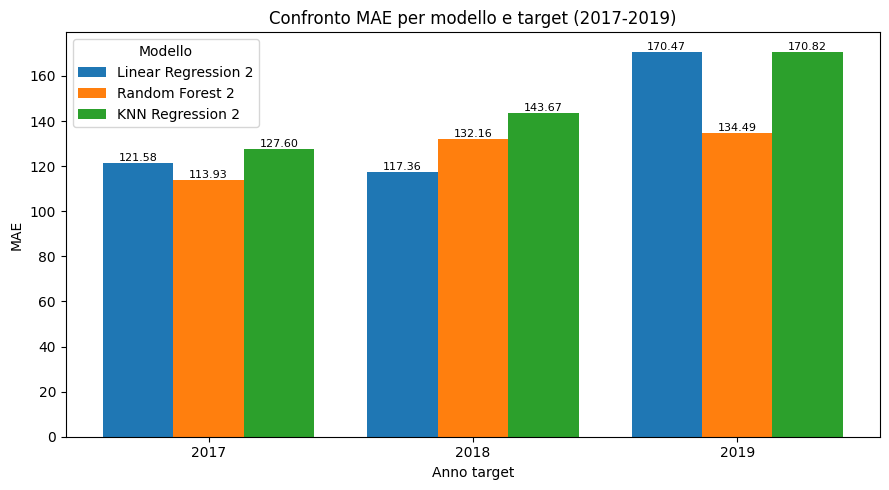

In [ ]:
# Calcola MAE
mae_values = {
    'Linear Regression 2': [
        mean_absolute_error(y_test1, y_lr1_pred_2),
        mean_absolute_error(y_test2, y_lr2_pred_2),
        mean_absolute_error(y_test3, y_lr3_pred_2)
    ],
    'Random Forest 2': [
        mean_absolute_error(y_test1, y_rf1_pred_2),
        mean_absolute_error(y_test2, y_rf2_pred_2),
        mean_absolute_error(y_test3, y_rf3_pred_2)
    ],
    'KNN Regression 2': [
        mean_absolute_error(y_test1, y_knn1_pred_2),
        mean_absolute_error(y_test2, y_knn2_pred_2),
        mean_absolute_error(y_test3, y_knn3_pred_2)
    ]
}

models = list(mae_values.keys())
targets = ['2017', '2018', '2019']
vals = np.array([mae_values[m] for m in models])  # shape (n_models, 3)

x = np.arange(len(targets))
n = len(models)
width = 0.8 / n

fig, ax = plt.subplots(figsize=(9,5))
for i, m in enumerate(models):
    ax.bar(x + (i - (n-1)/2)*width, vals[i], width=width, label=m)

ax.set_xticks(x)
ax.set_xticklabels(targets)
ax.set_xlabel('Anno target')
ax.set_ylabel('MAE')
ax.set_title('Confronto MAE per modello e target (2017-2019)')
ax.legend(title='Modello')
for i in range(n):
    for j in range(len(targets)):
        ax.text(x[j] + (i - (n-1)/2)*width, vals[i,j], f'{vals[i,j]:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
#training modelli su più features (inclusi generation_2017_gwh e generation_2018_gwh)
#rispetto ai casi precedenti abbiamo più features per predire generation_2019_gwh(abbiamo aggiunto generation_2017_gwh e generation_2018_gwh), ma abbiamo meno righe (perché molte righe hanno NaN in generation_2017_gwh o generation_2018_gwh)

features2 = ['capacity_gw','generation_2013_gwh','generation_2014_gwh','generation_2015_gwh','generation_2016_gwh','generation_2017_gwh','generation_2018_gwh']
features3 = ['commissioning_year','country_name','capacity_gw','latitude','longitude','primary_fuel','generation_2013_gwh','generation_2014_gwh','generation_2015_gwh','generation_2016_gwh','generation_2017_gwh','generation_2018_gwh']
target4 = 'generation_2019_gwh'
data = df[features2]
data_corr = df[features3]
data4 = df[[target4]]

# combino feature e target e rimuovo righe con NaN nelle colonne selezionate
combined4 = pd.concat([data, data4], axis=1) 
combined5 = pd.concat([data_corr, data4], axis=1)    

n_before4 = combined4.shape[0]  
n_before5 = combined5.shape[0] 


# rimuovo righe con NaN nelle colonne selezionate (dropna)
combined_clean4 = combined4.dropna()
combined_clean5 = combined5.dropna()

n_after4 = combined_clean4.shape[0]
n_after5 = combined_clean5.shape[0]

print(f"Rows before: {n_before4}, after dropna: {n_after4} (dropped {n_before4-n_after4})")
print(f"Rows before: {n_before5}, after dropna: {n_after5} (dropped {n_before5-n_after5})")

# estraggo X e y da dati puliti
x4 = combined_clean4[features2].values
y4 = combined_clean4[target4].values
x5 = combined_clean5[features3].values
y5 = combined_clean5[target4].values

print('X4 shape:', x4.shape, 'y4 shape:', y4.shape)
print('X5 shape:', x5.shape, 'y5 shape:', y5.shape)

if x4.shape[0] == 0:
    raise ValueError('No rows left after dropping NaN in dataset 4. Consider imputing missing values instead.')
if x5.shape[0] == 0:
    raise ValueError('No rows left after dropping NaN in dataset 5. Consider imputing missing values instead.')

# divido in training e test set (80% train, 20% test), senza shuffle 
X_train4, X_test4, y_train4, y_test4 = train_test_split(x4, y4, test_size=0.2, shuffle=False)
X_train5, X_test5, y_train5, y_test5 = train_test_split(x5, y5, test_size=0.2, shuffle=False)

# converti y in vettore 1D per evitare DataConversionWarning
y_train4 = y_train4.ravel()
y_test4 = y_test4.ravel()
y_train5 = y_train5.ravel()
y_test5 = y_test5.ravel()

print('')
print( "*** Risultati con più feature (inclusi generation_gwh_2017 e generation_gwh_2018) ***")
print("*** Linear Regression 4 ***")
clf = LinearRegression()
clf.fit(X_train4, y_train4)
y_lr4_pred = clf.predict(X_test4)
print('MAE:', mean_absolute_error(y_test4, y_lr4_pred))
print('MSE:', mean_squared_error(y_test4, y_lr4_pred))

print("*** Random Forest 4 ***")
clf = RandomForestRegressor()
clf.fit(X_train4, y_train4)
y_rf4_pred = clf.predict(X_test4)
print('MAE:', mean_absolute_error(y_test4, y_rf4_pred))
print('MSE:', mean_squared_error(y_test4, y_rf4_pred))

print("*** KNN Regression 4 ***")
clf = KNeighborsRegressor(n_neighbors=20)
clf.fit(X_train4, y_train4)
y_knn4_pred = clf.predict(X_test4)
print('MAE:', mean_absolute_error(y_test4, y_knn4_pred))
print('MSE:', mean_squared_error(y_test4, y_knn4_pred))

print('')
print("*** Risultati con tutte le feature (inclusi commissioning_year, country_name, latitude, longitude, primary_fuel) ***")

print("*** Linear Regression 5 ***")
clf = LinearRegression()
clf.fit(X_train5, y_train5)
y_lr5_pred = clf.predict(X_test5)
print('MAE:', mean_absolute_error(y_test5, y_lr5_pred))
print('MSE:', mean_squared_error(y_test5, y_lr5_pred))

print("*** Random Forest 5 ***")
clf = RandomForestRegressor()
clf.fit(X_train5, y_train5)
y_rf5_pred = clf.predict(X_test5)
print('MAE:', mean_absolute_error(y_test5, y_rf5_pred))
print('MSE:', mean_squared_error(y_test5, y_rf5_pred))

print("*** KNN Regression 5 ***")
clf = KNeighborsRegressor(n_neighbors=20)
clf.fit(X_train5, y_train5)
y_knn5_pred = clf.predict(X_test5)
print('MAE:', mean_absolute_error(y_test5, y_knn5_pred))
print('MSE:', mean_squared_error(y_test5, y_knn5_pred))


Rows before: 34936, after dropna: 6030 (dropped 28906)
Rows before: 34936, after dropna: 6030 (dropped 28906)
X4 shape: (6030, 7) y4 shape: (6030,)
X5 shape: (6030, 12) y5 shape: (6030,)

*** Risultati con più feature (inclusi generation_gwh_2017 e generation_gwh_2018) ***
*** Linear Regression 4 ***
MAE: 151.58991662759814
MSE: 269108.64613990684
*** Random Forest 4 ***
MAE: 111.6946671338534
MSE: 170081.77282536242
*** KNN Regression 4 ***
MAE: 133.49109286898837
MSE: 367036.4044648889

*** Risultati con tutte le feature (inclusi commissioning_year, country_name, latitude, longitude, primary_fuel) ***
*** Linear Regression 5 ***
MAE: 156.71955830327232
MSE: 269137.0599123022
*** Random Forest 5 ***
MAE: 109.72279693200669
MSE: 166800.75784839093
*** KNN Regression 5 ***
MAE: 151.51879063018242
MSE: 445983.90762976353


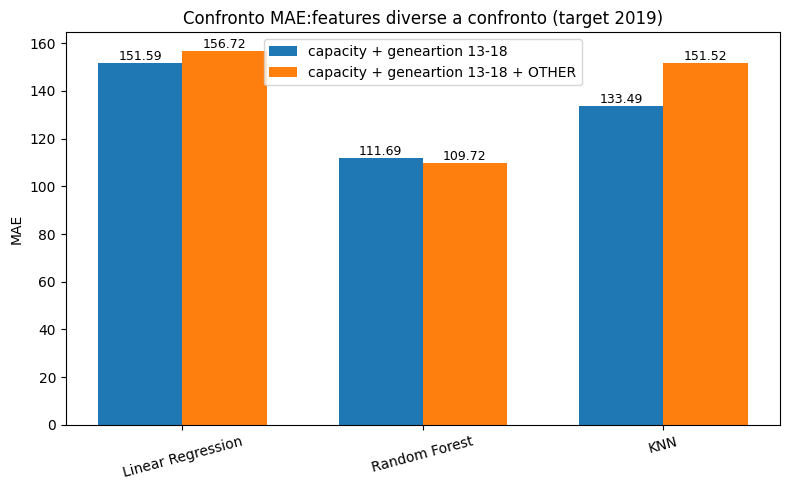

In [ ]:

# Controllo variabili attese
req = ['y_test4','y_test5','y_lr4_pred','y_rf4_pred','y_knn4_pred','y_lr5_pred','y_rf5_pred','y_knn5_pred']
miss = [v for v in req if v not in globals()]
if miss:
    raise NameError(f"Variabili mancanti nel kernel: {miss}. Esegui le celle che allenano i modelli su combined4/combined5.")

# Calcola MAE per ciascun modello 
mae4 = [
    mean_absolute_error(y_test4, y_lr4_pred),
    mean_absolute_error(y_test4, y_rf4_pred),
    mean_absolute_error(y_test4, y_knn4_pred)
]
mae5 = [
    mean_absolute_error(y_test5, y_lr5_pred),
    mean_absolute_error(y_test5, y_rf5_pred),
    mean_absolute_error(y_test5, y_knn5_pred)
]

models = ['Linear Regression', 'Random Forest', 'KNN']
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
bars1 = ax.bar(x - width/2, mae4, width, label='capacity + geneartion 13-18', color='C0')
bars2 = ax.bar(x + width/2, mae5, width, label='capacity + geneartion 13-18 + OTHER', color='C1')

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.set_ylabel('MAE')
ax.set_title('Confronto MAE:features diverse a confronto (target 2019)')
ax.legend()
ax.axhline(0, color='k', linewidth=0.5, alpha=0.6)

# Etichette valori
for b in bars1 + bars2:
    h = b.get_height()
    ax.text(b.get_x() + b.get_width()/2, h, f'{h:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()